In [1]:
import mindspore
# mindspore.set_context(device_target='CPU')
# mindspore.set_context(device_target='GPU')
mindspore.set_context(device_target="Ascend")
mindspore.set_context(device_id=0)
mindspore.run_check()

MindSpore version:  2.1.0
The result of multiplication calculation is correct, MindSpore has been installed on platform [Ascend] successfully!


# 6 微调

微调（Fine-tuning）是指在预训练模型的基础上，针对特定任务进行额外训练的过程。通过微调，我们可以使预训练模型适应特定领域的任务，提高模型在这些任务上的表现，而无需从头开始训练一个新模型。

<img src="./images_llm/fig6.1.svg" width="600">

## 6.1 分类微调

在大语言模型领域，最常见的微调方法是指令微调和分类微调。

指令微调（Instruction Fine-tuning）是通过一组任务，使用特定指令来训练语言模型，从而提高其理解和执行自然语言提示中所描述任务的能力。这种方法使模型能够理解并执行用户以指令形式提出的各种任务。

<img src="./images_llm/fig6.2.svg" width="600">

分类微调（Classification Fine-tuning）是将预训练语言模型针对具体分类任务进行调整的过程。通过添加一个分类头（通常是一个简单的线性层），并使用带有标签的训练数据，模型学习将文本映射到特定类别。

<img src="./images_llm/fig6.3.svg" width="500">

在本章中，我们将重点关注分类微调，并演示如何将预训练的大语言模型微调为一个垃圾邮件分类器。

## 6.2 数据准备


数据准备是微调过程中的关键步骤。我们需要收集、整理和预处理适合目标任务的数据，以便模型能够有效学习。

<img src="./images_llm/fig6.4.svg" width="600">

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
#! pip install pandas

In [4]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


我们可以看到，该数据集包含了5,572条短信记录，每条记录都被标记为"ham"（正常短信）或"spam"（垃圾短信）。我们首先检查一下两个类别的分布情况：

In [5]:
print(df["Label"].value_counts())

ham     4825
spam     747
Name: Label, dtype: int64


数据集中存在类别不平衡的问题，"ham"类别有4,825条记录，而"spam"类别只有747条记录。为了避免模型偏向多数类别，我们需要对数据集进行欠采样处理，确保每个类别均包含747个实例：

In [6]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

spam    747
ham     747
Name: Label, dtype: int64


接下来，我们将字符串标签"ham"和"spam"转换为整数标签 0 和 1，这样更适合机器学习模型处理：

In [7]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})  

In [8]:
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


然后，我们创建一个 random_split 函数将数据集分成三部分：70％用于训练，10％用于验证，20％用于测试。这样的划分可以确保我们有足够的数据来训练模型，同时保留一部分数据用于验证模型表现和最终测试评估。

In [9]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 6.3 数据加载器

在处理文本数据时，我们面临一个常见的挑战：文本长度不一致。为了能够高效地进行批处理，我们需要统一每个批次中文本的长度。

我们当前处理的文本消息长度各不相同。要像处理固定大小的文本块那样对这些消息进行批处理，我们有两种选择：

- 将所有消息截断为数据集或批次中最短消息的长度。
- 将所有消息填充为数据集或批次中最长消息的长度。

第一种方案操作相对简单，但缺点是可能会丢失较长消息中的部分信息，因为截断操作会把超过最短长度的部分直接删除。因此，我们倾向于选择第二种方案，即保留消息的全部内容，以确保信息的完整性。第二种方案需要为较短的消息添加填充标记。这里使用的填充标记是 "<|endoftext|>"。

<img src="./images_llm/fig6.5.svg" width="600">


我们首先检查这个标记在GPT-2词汇表中的ID：

In [10]:
from transformers import GPT2Tokenizer
# 指定本地词汇表文件所在的目录路径
local_path = "./gpt2-tokenizer"

# 从本地路径加载GPT - 2分词器
tokenizer = GPT2Tokenizer.from_pretrained(local_path)
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


[50256]


接下来，我们基于上述概念定义SpamDataset类。该类的关键职责包括：识别训练数据集中最长的序列、对文本消息进行编码、对序列进行填充，确保所有输入数据都具有相同的长度。

In [11]:
import mindspore
from mindspore.dataset import GeneratorDataset
from mindspore import Tensor

class SpamDataset:
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            # Tensor(encoded, dtype=mindspore.int64),
            # Tensor(label, dtype=mindspore.int64)
            encoded, label
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # Note: A more pythonic version to implement this method
        # is the following, which is also used in the next chapter:
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)

创建训练数据集实例，并获取数据集中最长序列的长度：

In [12]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


接下来，我们对验证集和测试集进行填充，使其长度与最长训练序列保持一致：


In [13]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

如果设定批大小为8，那么每个批次将包含8个长度为120的训练样本，以及每个样本对应的类标签（0表示正常短信，1表示垃圾短信）。


<img src="./images_llm/fig6.6.svg" width="600">

In [14]:
num_workers = 0
batch_size = 8

mindspore.set_seed(123)

train_loader = GeneratorDataset(train_dataset, ["input_ids", "target_ids"], shuffle=True)
train_loader = train_loader.batch(batch_size, drop_remainder=True)

val_loader = GeneratorDataset(val_dataset, ["input_ids", "target_ids"], shuffle=True)
val_loader = val_loader.batch(batch_size, drop_remainder=False)

test_loader = GeneratorDataset(test_dataset, ["input_ids", "target_ids"], shuffle=True)
test_loader = test_loader.batch(batch_size, drop_remainder=False)


以下代码创建了训练集、验证集和测试集的数据加载器，并以每批8个样本的形式加载文本消息及其对应的标签：

In [15]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: (8, 120)
Label batch dimensions (8,)


In [16]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 6.4 使用预训练权重初始化模型

分类微调的一个关键优势是能够利用预训练模型已经学到的知识。我们将使用预训练的GPT-2模型作为起点，并在此基础上进行垃圾邮件分类任务的微调。

<img src="./images_llm/fig6.7.svg" width="600">

首先，我们定义模型的配置参数：

In [17]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

接下来，我们下载并加载预训练的GPT-2权重：

In [18]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.set_train(False)

[WARNING] ME(215213:281473029364592,MainProcess):2025-03-13-20:08:09.427.058 [mindspore/nn/layer/basic.py:171] This parameter `dtype` will be deleted or invisible in the future. Please don't use it.


GPTModel<
  (tok_emb): Embedding<vocab_size=50257, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=embedding_table, shape=(50257, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (pos_emb): Embedding<vocab_size=1024, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=embedding_table, shape=(1024, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (drop_emb): Dropout<p=0.0>
  (trf_blocks): SequentialCell<
    (0): TransformerBlock<
      (att): MultiHeadAttention<
        (W_query): Dense<input_channels=768, output_channels=768, has_bias=True>
        (W_key): Dense<input_channels=768, output_channels=768, has_bias=True>
        (W_value): Dense<input_channels=768, output_channels=768, has_bias=True>
        (out_proj): Dense<input_channels=768, output_channels=768, has_bias=True>
        (dropout): Dropout<p=0.0>
        >
      (ff): FeedForward<
        (layers): SequentialCell<
         

复用先前章节定义的函数：

In [19]:
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.numpy as np

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        # with mindspore.context.grad_off():
        logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        softmax = ops.Softmax(axis=-1)
        probas = softmax(logits)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = ops.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = ops.concat((idx, idx_next), axis=1)  # (batch, n_tokens+1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = Tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
     # 检查是否有批量维度，如果有则移除
    if len(token_ids.shape) > 1 and token_ids.shape[0] == 1:
        flat = token_ids.squeeze(0)
    else:
        flat = token_ids
    # flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat)

将模型权重加载到 GPTModel，以确保模型生成连贯的文本：

In [20]:

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you forward.

The first step is to understand the importance of your work


接下来，我们测试一下模型是否能够区分垃圾邮件和正常邮件：

In [21]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Is the following text'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text'spam'? Answer with 'yes' or 'no': 'You are a winner


从输出结果来看，模型在遵循指令方面存在困难。这是因为模型没有进行过指令微调，无法理解并执行特定的指令任务。这也正是我们需要进行分类微调的原因，通过微调使模型能够执行垃圾邮件分类任务。

## 6.5 添加分类头

为了对预训练的LLM进行分类微调，我们需要对模型结构进行修改。具体来说，我们将原始的输出层（用于预测下一个词元的概率分布）替换为一个更小的输出层，这个输出层仅映射到两个类别：0（正常短信）和1（垃圾短信）。

<img src="./images_llm/fig6.8.svg" width="700">

先通过 print(model) 打印未经修改的模型架构：

In [22]:
print(model)

GPTModel<
  (tok_emb): Embedding<vocab_size=50257, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=tok_emb.embedding_table, shape=(50257, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (pos_emb): Embedding<vocab_size=1024, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=pos_emb.embedding_table, shape=(1024, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (drop_emb): Dropout<p=0.0>
  (trf_blocks): SequentialCell<
    (0): TransformerBlock<
      (att): MultiHeadAttention<
        (W_query): Dense<input_channels=768, output_channels=768, has_bias=True>
        (W_key): Dense<input_channels=768, output_channels=768, has_bias=True>
        (W_value): Dense<input_channels=768, output_channels=768, has_bias=True>
        (out_proj): Dense<input_channels=768, output_channels=768, has_bias=True>
        (dropout): Dropout<p=0.0>
        >
      (ff): FeedForward<
        (layers): Sequentia

为了让模型做好分类微调的准备，我们首先冻结模型，确保所有层都处于不可训练状态：

In [23]:
for param in model.trainable_params():
    param.requires_grad = False

替换输出层（model.out_head），将其改为一个具有两个输出单元的线性层，分别对应"正常短信"和"垃圾短信"两个类别：

In [24]:
import mindspore.nn as nn
mindspore.set_seed(456)

num_classes = 2
model.out_head = nn.Dense(in_channels=BASE_CONFIG["emb_dim"], out_channels=num_classes)

新添加的`model.out_head`输出层，其`require_grad`属性默认设置为`True`，意味着在训练过程中，它是模型中唯一会自动更新的层。理论上，仅训练这个新添加的输出层就足够了。然而，通过实验发现，微调额外的层能显著提升模型的预测性能。因此，我们把最后一个`Transformer`块以及连接该块到输出层的最后一个`LayerNorm`模块都设置为可训练状态。

<img src="./images_llm/fig6.9.svg" width="600">

In [25]:
for param in model.trf_blocks[-1].trainable_params():
    param.requires_grad = True

for param in model.final_norm.trainable_params():
    param.requires_grad = True

In [26]:
inputs = tokenizer.encode("Do you have time")
inputs = Tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: [[5211  345  423  640]]
Inputs dimensions: (1, 4)


In [27]:
outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 [[[ 3.1096196  0.5925137]
  [10.461748   4.008141 ]
  [ 7.6329713  3.6736956]
  [ 7.2209086  2.8772314]]]
Outputs dimensions: (1, 4, 2)


由于我们替换了模型的输出层，因此每个输出的嵌入维度（列数）是 2。我们的目标是微调此模型，使其返回一个类标签，以指示模型输入是“垃圾邮件”还是“正常邮件”。在这个过程中，我们无需微调所有四个输出行；只需专注于单个输出标记。具体来说，我们将重点关注与最后一个输出词元相对应的最后一行。

<img src="./images_llm/fig6.10.svg" width="600">

In [28]:

print("Last output token:", outputs[:, -1, :])

Last output token: [[7.2209086 2.8772314]]


在之前的章节中，我们已经深入探讨了注意力机制，它能够在每个输入词元和其他所有输入词元之间建立关系。自注意力机制中使用的因果掩码（causal mask）将词元的注意力范围限制在其当前位置及之前的位置，从而确保每个词元只能受到其自身以及前面词元的影响，如图所示。

<img src="./images_llm/fig6.11.svg">

根据图中展示的因果注意掩码配置，序列中的最后一个词元积累了最丰富的信息，因为它是唯一可以访问并整合所有先前词元数据的词元。因此，我们使用最后一个词元的输出作为分类决策的依据。


## 6.6 计算分类损失和准确率

为了训练和评估我们的分类模型，我们需要定义适当的损失函数和评估指标。

用于训练分类模型的损失函数通常是交叉熵损失，它衡量预测分布与真实分布之间的距离。而评估分类性能的常用指标是准确率，它反映了模型正确预测的比例。

<img src="./images_llm/fig6.12.svg" width="600">

首先，我们来简要讨论一下如何将模型输出转换为类标签预测。

<img src="./images_llm/fig6.13.svg" width="800">

In [29]:
print("Last output token:", outputs[:, -1, :])

Last output token: [[7.2209086 2.8772314]]


调用softmax函数将输出logits转换为概率分布，然后通过 argmax 函数返回最高概率的位置：

In [30]:
import mindspore.ops as ops
softmax = nn.Softmax(axis=-1)
probas = softmax(outputs[:, -1, :])
label = ops.argmax(probas)
print("Class label:", label.item())

Class label: 0


In [31]:
logits = outputs[:, -1, :]
label = ops.argmax(logits)
print("Class label:", label.item())

Class label: 0


定义calc_accuracy_loader函数来计算正确预测的比例：

In [32]:
def calc_accuracy_loader(data_loader, model, num_batches=None):
    model.set_train(False)
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            logits = model(input_batch)[:, -1, :]  # Logits of last output token
            # print(logits)
            predicted_labels = ops.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return float(correct_predictions) / float(num_examples)

In [33]:
mindspore.set_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, num_batches=10)

print(f"Training  accuracy: {train_accuracy*100:.4f}%")
print(f"Validation accuracy: {val_accuracy*100:.4f}%")
print(f"Test accuracy: {test_accuracy*100:.4f}%")

Training  accuracy: 47.5000%
Validation accuracy: 45.0000%
Test accuracy: 47.5000%


接下来，我们为损失计算定义一个辅助函数calc_loss_batch：

In [34]:
def calc_loss_batch(input_batch, target_batch, model):
    output = model(input_batch)
    # print("output:", output)
    logits = output[:, -1, :]  # Logits of last output token
    # print("logits", logits)
    loss = ops.cross_entropy(logits, target_batch)
    # print("loss", loss)
    return loss

为了计算所有批次的损失，定义 `calc_loss_loader` 函数如下：

In [35]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, num_batches=None):
    model.set_train(False)
    total_loss = 0.
    # print(len(data_loader))
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model)
            # print(loss)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

现在，我们来计算训练集、验证集以及测试集上的初始损失：

In [36]:
train_loss = calc_loss_loader(train_loader, model, num_batches=5)
val_loss = calc_loss_loader(val_loader, model, num_batches=5)
test_loss = calc_loss_loader(test_loader, model, num_batches=5)

print(f"Training loss: {train_loss.asnumpy():.3f}")
print(f"Validation loss: {val_loss.asnumpy():.3f}")
print(f"Test loss: {test_loss.asnumpy():.3f}")

Training loss: 2.301
Validation loss: 2.073
Test loss: 2.183


## 6.7 在监督数据上微调模型

接下来，我们需要定义训练函数`train_classifier_simple`来微调预训练的 LLM 以提高垃圾邮件分类的准确率。

<img src="./images_llm/fig6.14.svg">

这个训练函数的实现理念与用于预训练模型的 `train_model_simple` 函数相似，但有两个主要区别：

1. 当前追踪的是训练示例数量（examples_seen）而不是词元数量
2. 每个训练周期结束后计算准确率而不是打印生成的文本。

In [37]:
from mindspore import value_and_grad
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.set_train(True)  # Set model to training mode
        # 定义前向传播函数
        def forward_fn(input_batch, target_batch):
            loss = calc_loss_batch(input_batch, target_batch, model)
            return loss
        # 获取计算梯度的函数
        grad_fn = value_and_grad(forward_fn, None, optimizer.parameters)

        for input_batch, target_batch in train_loader:
            # optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            # loss = calc_loss_batch(input_batch, target_batch, model)
            # loss.backward() # Calculate loss gradients
            # optimizer.step() # Update model weights using loss gradients
            #
            # 计算损失和梯度
            loss, grads = grad_fn(input_batch, target_batch)
            # 使用优化器更新参数
            optimizer(grads)

            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss.asnumpy():.3f}, Val loss {val_loss.asnumpy():.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [38]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, eval_iter):
    model.set_train(False)
    train_loss = calc_loss_loader(train_loader, model, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, num_batches=eval_iter)
    model.set_train(True)
    return train_loss, val_loss

接下来，我们将初始化优化器，设置训练周期，并调用train_classifier_simple函数开始训练。我们选择了AdamW优化器，该优化器在Adam的基础上增加了权重衰减正则化，有助于减少过拟合风险。

In [39]:
import time

start_time = time.time()

mindspore.set_seed(123)

optimizer = nn.AdamWeightDecay(model.trainable_params(), learning_rate=5e-5, weight_decay=1e-4)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.206, Val loss 1.987
Ep 1 (Step 000050): Train loss 0.669, Val loss 0.657
Ep 1 (Step 000100): Train loss 0.658, Val loss 0.659
Training accuracy: 77.50% | Validation accuracy: 85.00%
Ep 2 (Step 000150): Train loss 0.643, Val loss 0.633
Ep 2 (Step 000200): Train loss 0.640, Val loss 0.610
Ep 2 (Step 000250): Train loss 0.625, Val loss 0.600
Training accuracy: 85.00% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.649, Val loss 0.598
Ep 3 (Step 000350): Train loss 0.614, Val loss 0.578
Training accuracy: 85.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.604, Val loss 0.573
Ep 4 (Step 000450): Train loss 0.598, Val loss 0.564
Ep 4 (Step 000500): Train loss 0.596, Val loss 0.569
Training accuracy: 85.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.596, Val loss 0.545
Ep 5 (Step 000600): Train loss 0.588, Val loss 0.538
Training accuracy: 85.00% | Validation accuracy: 95.00%
Training completed in 18.17 min

In [40]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

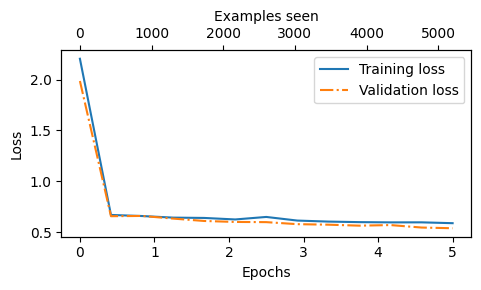

In [41]:
epochs_tensor = ops.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = ops.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

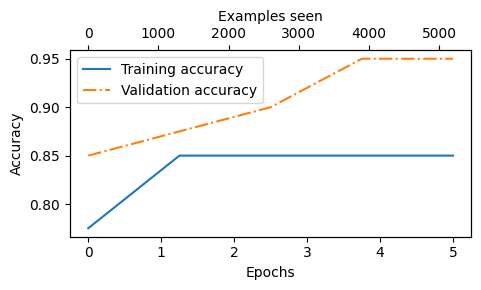

In [42]:
epochs_tensor = ops.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = ops.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

运行以下代码，以计算微调后的LLM在训练集、验证集和测试集上的准确率:

In [43]:
train_accuracy = calc_accuracy_loader(train_loader, model)
val_accuracy = calc_accuracy_loader(val_loader, model)
test_accuracy = calc_accuracy_loader(test_loader, model)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 85.29%
Validation accuracy: 88.59%
Test accuracy: 85.33%


## 6.8 使用LLM实现垃圾邮件分类器

现在，我们已经成功地将预训练的LLM微调为一个垃圾邮件分类器。接下来，我们将定义一个函数来使用这个分类器对新的文本进行分类。

<img src="./images_llm/fig6.15.svg" width="600">

以下定义的 classify_review 函数与之前 SpamDataset 类中使用的数据预处理步骤类似。该函数将文本分词处理为词元ID后，使用微调后的模型预测得到一个类别标签，并返回相应的类名（"spam"或"not spam"）。

In [44]:
def classify_review(text, model, tokenizer, max_length=None, pad_token_id=50256):
    model.set_train(False)

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.embedding_table.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = mindspore.Tensor(input_ids).unsqueeze(0) # add batch dimension

    # Model inference
    
    logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = ops.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

让我们测试一下这个分类器在实际文本上的表现：

In [50]:
text_1 = (
    "Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123"
)

print(classify_review(\
    text_1, model, tokenizer, max_length=train_dataset.max_length
))

spam


In [51]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, max_length=train_dataset.max_length
))

not spam


最后，我们将微调好的模型保存到文件中，以便将来使用：

In [52]:
mindspore.save_checkpoint(model, "review_classifier.ckpt")

In [53]:
model = GPTModel(BASE_CONFIG)
import mindspore.nn as nn
mindspore.set_seed(456)

num_classes = 2
model.out_head = nn.Dense(in_channels=BASE_CONFIG["emb_dim"], out_channels=num_classes)


param_dict = mindspore.load_checkpoint("review_classifier.ckpt")
param_not_load, _ = mindspore.load_param_into_net(model, param_dict)
print(param_not_load) # param_not_load是未被加载的参数列表，为空时代表所有参数均加载成功。
model.set_train(False)

[WARNING] ME(215213:281473029364592,MainProcess):2025-03-13-20:46:18.714.200 [mindspore/nn/layer/basic.py:171] This parameter `dtype` will be deleted or invisible in the future. Please don't use it.


[]


GPTModel<
  (tok_emb): Embedding<vocab_size=50257, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=tok_emb.embedding_table, shape=(50257, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (pos_emb): Embedding<vocab_size=1024, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=pos_emb.embedding_table, shape=(1024, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (drop_emb): Dropout<p=0.0>
  (trf_blocks): SequentialCell<
    (0): TransformerBlock<
      (att): MultiHeadAttention<
        (W_query): Dense<input_channels=768, output_channels=768, has_bias=True>
        (W_key): Dense<input_channels=768, output_channels=768, has_bias=True>
        (W_value): Dense<input_channels=768, output_channels=768, has_bias=True>
        (out_proj): Dense<input_channels=768, output_channels=768, has_bias=True>
        (dropout): Dropout<p=0.0>
        >
      (ff): FeedForward<
        (layers): Sequentia

## 6.9 总结

在本章中，我们学习了如何对预训练的大语言模型进行分类微调，使其能够执行垃圾邮件分类任务。我们的主要工作包括：

1. 数据准备：下载SMS垃圾邮件数据集，进行预处理和平衡处理，并将数据集分为训练集、验证集和测试集。
2. 数据加载：创建自定义的SpamDataset类，处理不同长度的文本序列，并使用填充统一序列长度。
3. 模型修改：加载预训练的GPT-2模型，冻结大部分参数，并添加一个分类头用于二分类任务。
4. 微调训练：定义损失函数和评估指标，使用AdamW优化器对模型进行训练，并监控训练和验证性能。
5. 模型部署：创建一个简单的分类函数，将微调后的模型应用于新的文本，实现垃圾邮件检测。

微调是一种强大的技术，它允许我们利用预训练模型的知识，使用相对较少的数据和计算资源来解决特定任务。通过本章的学习，我们看到了如何将通用的语言模型转变为专门的文本分类工具，这种方法可以扩展到许多其他自然语言处理任务，如情感分析、主题分类、意图识别等。

在下一章中，我们将探索更多的微调技术和应用场景，进一步挖掘大语言模型的潜力。